# Midterm Notebook for Exploration along with the Results

In [2]:
import numpy as np, random, os
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv(Path('../data/KaggleStudentsData.csv'))
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## Some Basic Checks

In [3]:
df.info()
print("--------------------------------------------------------------------------------------------------------")
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
--------------------------------------------------------------------------------------------------------


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,female,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race/ethnicity,1000,5,group C,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental level of education,1000,6,some college,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test preparation course,1000,2,none,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math score,1000.0,NaN,NaN,NaN,66.089,15.16308,0.0,57.0,66.0,77.0,100.0
reading score,1000.0,NaN,NaN,NaN,69.169,14.600192,17.0,59.0,70.0,79.0,100.0
writing score,1000.0,NaN,NaN,NaN,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


## Getting the average of the three classes, 0 or 1 for parents college level, and final letter grades based off average

In [4]:
COL_MAP = {
    "gender": "gender",
    "race/ethnicity": "race_ethnicity",
    "parental level of education": "parent_edu",
    "lunch": "lunch",
    "test preparation course": "test_prep",
    "math score": "math",
    "reading score": "reading",
    "writing score": "writing",
}


# FEATURE STUFF HERE <-----------------------------

df = df.rename(columns=COL_MAP)
df['avg_score'] = df[['math','reading','writing']].mean(axis=1)

Went_To_College = {"bachelor","master","associate","college","some college"}
def went_to_college(x: str) -> int:
    x = str(x).lower()
    return int(any(tok in x for tok in Went_To_College))
df['parent_college'] = df['parent_edu'].map(went_to_college)

def to_letter(avg: float) -> str:
    if avg >= 90: return "A"
    if avg >= 80: return "B"
    if avg >= 70: return "C"
    if avg >= 60: return "D"
    return "F"
df['letter_grade'] = df['avg_score'].apply(to_letter)

df[['avg_score','parent_college','letter_grade']].head()


,avg_score,parent_college,letter_grade
0,72.666667,1,C
1,82.333333,1,B
2,92.666667,1,A
3,49.333333,1,F
4,76.333333,1,C


## Get the graph and the distributions of the letter grades

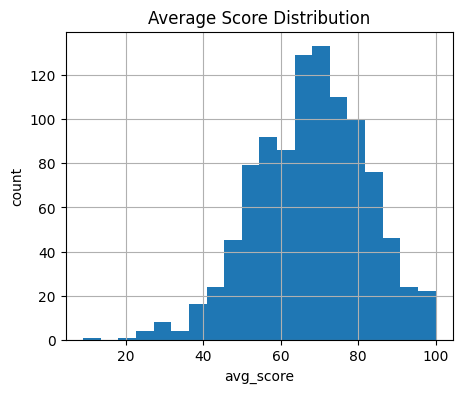

--------------------------------------------------------------------------------------------------------
letter_grade
A     52
B    146
C    261
D    256
F    285


In [6]:
plt.figure(figsize=(5,4))
df['avg_score'].hist(bins=20)
plt.title('Average Score Distribution')
plt.xlabel('avg_score')
plt.ylabel('count')
plt.show()
print("--------------------------------------------------------------------------------------------------------")
print(df['letter_grade'].value_counts().sort_index().to_string())


## Modeling

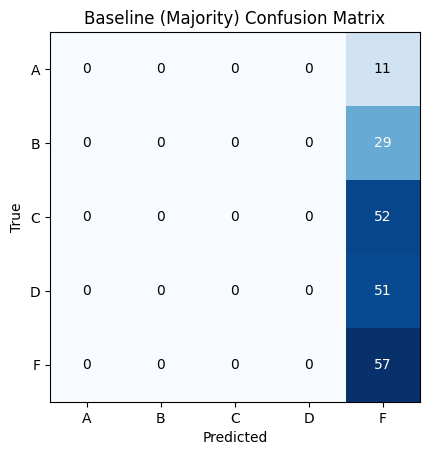

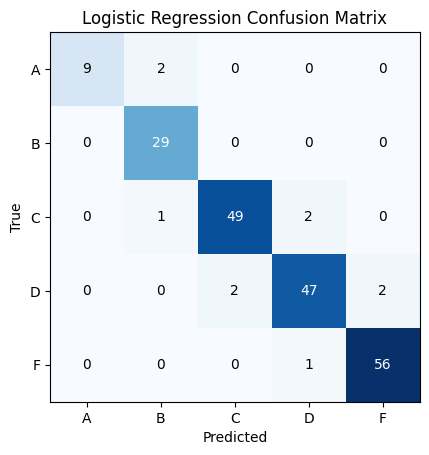

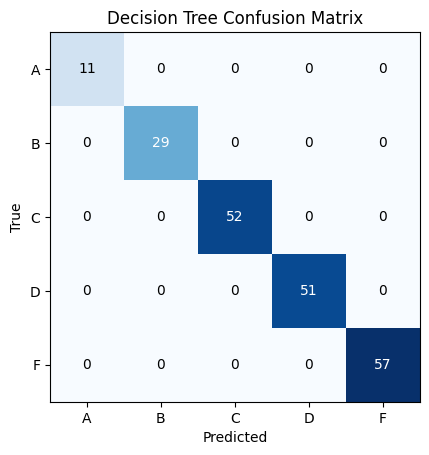

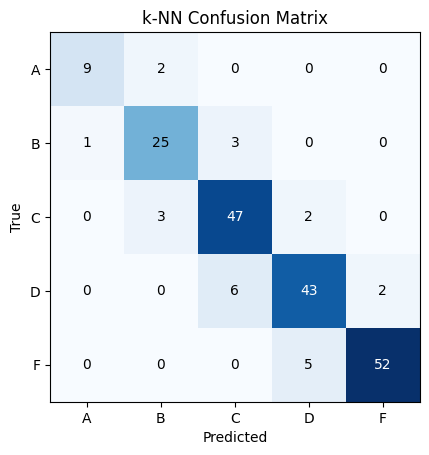

,Model,CV F1 (mean),Test Accuracy,Test F1 Macro
2,Decision Tree,1.00000,1.000,1.00000
1,Logistic Regression,0.93449,0.950,0.94138
3,k-NN,0.80869,0.880,0.87268
0,Baseline (Majority),0.08871,0.285,0.08872


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import pandas as pd

cat_cols = ["gender", "race_ethnicity", "parent_edu", "lunch", "test_prep"]
num_cols = ["math", "reading", "writing", "avg_score", "parent_college"]

X = df[cat_cols + num_cols]
y = df["letter_grade"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


# PREPROCESSING IS RIGHT HERE <-----------------------------

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

models = {
    "Baseline (Majority)": DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE),
    "Logistic Regression": LogisticRegression(max_iter=300, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "k-NN": KNeighborsClassifier(n_neighbors=10)
}

def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.xticks(range(len(labels)), labels)
    plt.yticks(range(len(labels)), labels)
    plt.show()

results = []
labels = sorted(y.unique())
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    pipe = Pipeline([("prep", preprocessor), ("clf", model)])
    cv_score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_macro").mean()

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results.append({
        "Model": name,
        "mean": round(cv_score, 5),
        "Test Accuracy": round(accuracy_score(y_test, y_pred), 5),
        "Test F1 Macro": round(f1_score(y_test, y_pred, average="macro"), 5)
    })

    plot_confusion(y_test, y_pred, labels, f"{name} Confusion Matrix")

pd.DataFrame(results).sort_values("Test F1 Macro", ascending=False)
